In [12]:
import numpy as np
import pandas as pd

Notes:
- check why is better to use PCA before K-means
- check if is reasonable to cluster using pca with 0.8 and then plot using again PCA but on only 2 or 3 components

Let's read the dataset

Our goal is to use K-means to find patterns between patients

In [13]:
df = pd.read_csv("/Users/simoneboesso/Desktop/PatientSegmentationCancer/leukemia_cancer_cell.tsv",sep="\t",on_bad_lines= "skip")

In [14]:
df.shape

(942, 68)

In [15]:
df.columns
# Cancer types for a multi-class classification 

Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Age At Specimen Acquisition', 'FLT3-ITD Allelic Ratio', 'ASXL1',
       'Cancer Type', 'Cancer Type Detailed', 'Cause Of Death',
       'CEBPA bi-allelic', 'Center ID', 'Cohort', 'Cumulative Chemo',
       'Unique Regiments', 'No. Of Cumulative Regiments',
       'Unique Treatment Stages', 'No. Of Unique Treatment Stages',
       'Unique Treatment Types', 'No. Of Cumulative Treatments',
       'Current Regimen', 'Current Stage',
       'Disease Stage At Specimen Collection', 'Diagnosis At Inclusion',
       'ELN2017', 'Ethnicity Category', 'FAB BLAST morphology', 'FLT3-ITD',
       'De Novo', 'Relapsed', 'Transformed', 'Karyotype',
       'Most Recent Treatment Duration', 'Most Recent Treatment Type',
       'Mutation Count', 'Diagnosis non AML, MDS, MPN', 'NPM1',
       'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status',
       'Other Cytogenetics', 'Prior Non-Myeloid', 'Prior Malignancy Rad

In [16]:
df.dtypes

Study ID                        object
Patient ID                      object
Sample ID                       object
Age at Diagnosis               float64
Age At Specimen Acquisition    float64
                                ...   
TMB (nonsynonymous)            float64
TP53 Pathway                    object
Treatment Type Induction        object
Used In Manuscript              object
Variant Summary                 object
Length: 68, dtype: object

In [17]:
nan_counts = df.isna().sum()
for column, count in nan_counts.items():
    print(f"Column '{column}': {count} NaN values")

Column 'Study ID': 0 NaN values
Column 'Patient ID': 0 NaN values
Column 'Sample ID': 0 NaN values
Column 'Age at Diagnosis': 26 NaN values
Column 'Age At Specimen Acquisition': 16 NaN values
Column 'FLT3-ITD Allelic Ratio': 78 NaN values
Column 'ASXL1': 842 NaN values
Column 'Cancer Type': 0 NaN values
Column 'Cancer Type Detailed': 0 NaN values
Column 'Cause Of Death': 32 NaN values
Column 'CEBPA bi-allelic': 896 NaN values
Column 'Center ID': 0 NaN values
Column 'Cohort': 0 NaN values
Column 'Cumulative Chemo': 0 NaN values
Column 'Unique Regiments': 78 NaN values
Column 'No. Of Cumulative Regiments': 2 NaN values
Column 'Unique Treatment Stages': 78 NaN values
Column 'No. Of Unique Treatment Stages': 2 NaN values
Column 'Unique Treatment Types': 78 NaN values
Column 'No. Of Cumulative Treatments': 2 NaN values
Column 'Current Regimen': 2 NaN values
Column 'Current Stage': 2 NaN values
Column 'Disease Stage At Specimen Collection': 29 NaN values
Column 'Diagnosis At Inclusion': 0 Na

Let's remove the columns with too many Nans

In [18]:
df.drop(["RUNX1","Other Cytogenetics","Type Non-Myeloid","FAB BLAST morphology","Response To Induction","Race Category","Treatment Type Induction","Ethnicity Category","Surface Antigens Immunohistochemical Stains","Response Duration To Induction","ASXL1","TP53 Pathway", "CEBPA bi-allelic","Variant Summary"], axis = 1, inplace=True)

In [19]:
df_cleaned = df.dropna().copy()
df_cleaned.shape

(675, 54)

Let's extract the info about the patient id

In [20]:
ids = df_cleaned.iloc[:,:3]
ids.head()
df.drop(["Study ID","Patient ID", "Sample ID"], axis = 1, inplace=True)

Let's convert the objects types to string and then perform a label encoding!

In [21]:
''' This iterate on each column, convert to string and then perform the label encoding! 
'''

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoder()
for i in df_cleaned:
    if df_cleaned[i].dtype == 'object':
        df_cleaned[i] = encoder.fit_transform(df_cleaned[i].astype(str))


In [22]:
df_cleaned.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,0,0,0,65.0,65.0,0.0,0,1,3,2,...,1,1,0,False,5,0,0,0,0.900000,1
1,0,1,1,68.0,68.0,0.0,0,1,1,5,...,1,1,0,False,6,13,0,34,1.033333,1
3,0,2,2,75.0,75.0,0.0,0,1,1,1,...,1,1,0,False,25,1,0,0,0.500000,1
4,0,3,3,52.0,53.0,0.0,0,0,1,1,...,1,1,1,False,21,17,2,234,0.066667,0
6,0,4,4,53.0,53.0,0.0,0,1,1,1,...,1,1,0,False,5,0,1,0,1.200000,1


Let's normalize!

In [23]:
scaler = StandardScaler()
standardized_df = scaler.fit_transform(df_cleaned)

# Principal Component Analysis

Let's first find the best number of components to use!

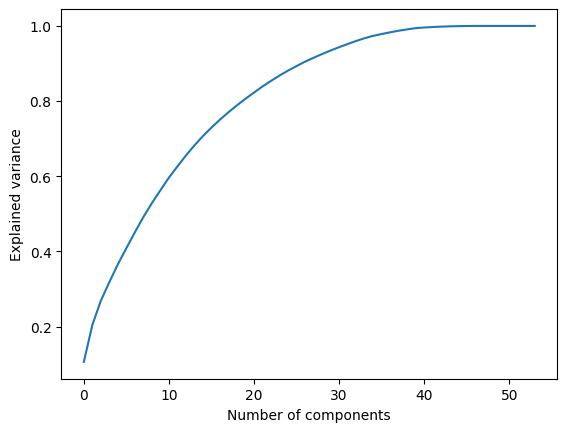

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(standardized_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()


Let's extract the dataset we'll use for the clustering after feature reduction

In [25]:
# We can do this to get the number of components that reach 0.8 of total variance
pca = PCA(n_components=0.8)
pca.fit(standardized_df)
reduce_df = pca.transform(standardized_df)
reduce_df.shape

(675, 20)

Clearly the dataset has less columns

Now for visualization reasons, let's use again the PCA with n_components = 2 and n_components = 3

In [26]:
pca = PCA(n_components=2)
reduce_df2 = pca.fit(standardized_df)
reduce_df2 = pca.transform(standardized_df)
reduce_df2 = pd.DataFrame(data = reduce_df2, columns=["PC1", "PC2"])
reduce_df2.shape


(675, 2)

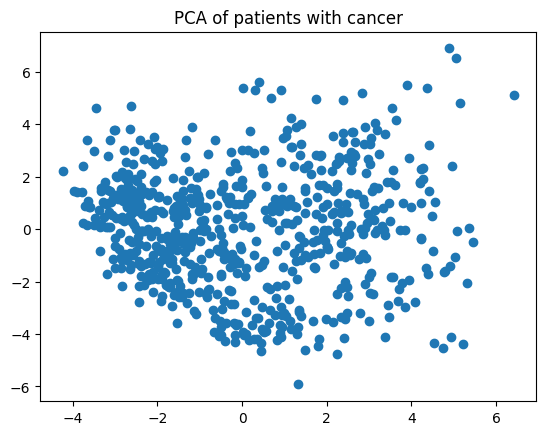

In [27]:
plt.scatter(reduce_df2["PC1"],reduce_df2["PC2"])
plt.title("PCA of patients with cancer")
plt.show()

Quite hard to find clusters here, maybe with a larger number of components we can see they are easy to distinguish

Let's try the same but in 3-D

In [28]:
pca3 = PCA(n_components=3)
reduce_df3 = pca3.fit(standardized_df)
reduce_df3 = pca3.transform(standardized_df)
reduce_df3 = pd.DataFrame(data = reduce_df3, columns=["PC1", "PC2", "PC3"])
reduce_df3.shape

(675, 3)

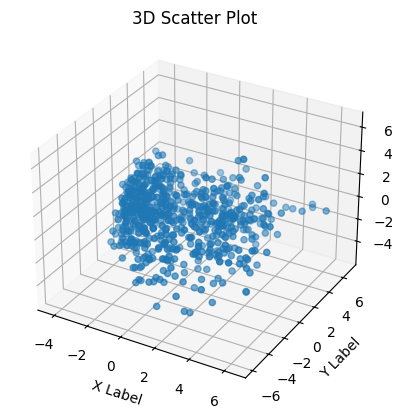

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = reduce_df3["PC1"]
y = reduce_df3["PC2"]
z = reduce_df3["PC3"]

ax.scatter(x, y, z)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')

plt.show()

Now, we want to use the k-means to find clusters and check visually if there are communities of patients with interesting patterns

# K-Means

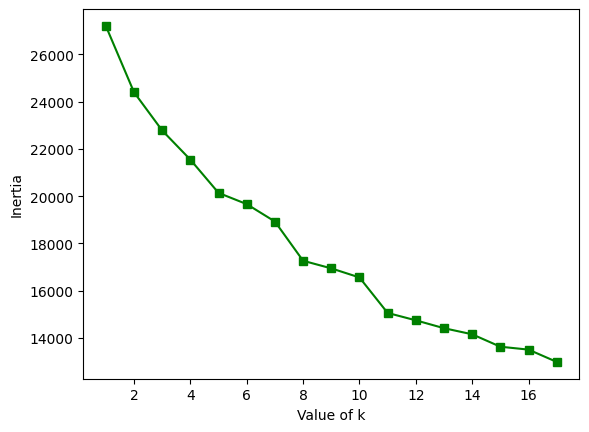

In [30]:
from sklearn.cluster import KMeans

inertia_scores = []
for i in range(1,18):
    model = KMeans(n_clusters=i, init = "k-means++",random_state=42)
    model.fit(reduce_df)
    inertia_scores.append(model.inertia_)

plt.plot(range(1,18),inertia_scores, 'gs-')
plt.xlabel("Value of k")
plt.ylabel("Inertia")
plt.show()

Let's find the best number of clusters using the elbow method

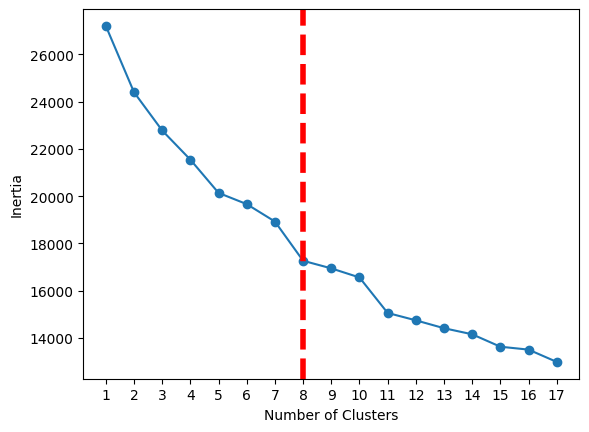

In [31]:
from kneed import KneeLocator
k1 = KneeLocator (range (1, 18), inertia_scores, curve = "convex", direction = "decreasing")
plt.plot (range (1,18), inertia_scores , marker = 'o')
plt.xticks (range (1, 18))
plt.xlabel ("Number of Clusters")
plt.ylabel ("Inertia")
plt.axvline (x = k1.elbow, color = "red", label = "axvline - full height",linewidth = 4, linestyle ="--")
plt.show()

The best number seems to be 8

Let's perform the classification

In [33]:
model = KMeans(n_clusters=8, random_state=42).fit(reduce_df)
preds = model.predict(reduce_df)
centers = model.cluster_centers_

Let's create a new dataframe where i merge  this new information (the cluster association) with the other features

In [43]:
pred_values = pd.DataFrame({'Preds': preds})

In [44]:
merged_df = pd.merge(pred_values, df_cleaned,left_index=True, right_index=True) # merge using the index of both dataframes
merged_df.head()

,Preds,Study ID,Patient ID,Sample ID,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,6,0,0,0,65.0,65.0,0.0,0,1,3,...,1,1,0,False,5,0,0,0,0.900000,1
1,5,0,1,1,68.0,68.0,0.0,0,1,1,...,1,1,0,False,6,13,0,34,1.033333,1
3,0,0,2,2,75.0,75.0,0.0,0,1,1,...,1,1,0,False,25,1,0,0,0.500000,1
4,3,0,3,3,52.0,53.0,0.0,0,0,1,...,1,1,1,False,21,17,2,234,0.066667,0
6,0,0,4,4,53.0,53.0,0.0,0,1,1,...,1,1,0,False,5,0,1,0,1.200000,1


In [45]:
count_averages = merged_df.groupby('Preds').mean()
count_averages

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
Preds,,,,,,,,,,,,,,,,,,,,,
0,0.0,180.060976,210.987805,54.048780,54.597561,0.562207,0.0,1.000000,1.121951,2.365854,...,1.512195,0.573171,0.439024,0.0,9.951220,7.768293,0.804878,74.475610,0.442276,0.719512
1,0.0,196.083333,229.666667,52.375000,52.541667,0.274457,0.0,1.000000,0.958333,2.291667,...,1.291667,0.583333,0.416667,0.0,9.541667,5.125000,0.750000,5.291667,0.406944,0.875000
2,0.0,345.438202,409.606742,60.820225,61.280899,0.708226,0.0,1.000000,1.044944,2.303371,...,1.449438,0.505618,0.426966,0.0,8.146067,6.179775,0.775281,61.707865,0.505618,0.764045
3,0.0,166.058824,194.364706,57.035294,57.576471,0.395941,0.0,0.976471,1.094118,2.094118,...,1.482353,0.564706,0.294118,0.0,8.247059,7.505882,0.729412,59.094118,0.560784,0.752941
4,0.0,192.235294,225.529412,56.098039,56.372549,0.566820,0.0,1.000000,1.039216,2.431373,...,1.470588,0.568627,0.313725,0.0,8.588235,6.588235,0.588235,79.039216,0.621569,0.686275
5,0.0,212.127660,249.765957,53.914894,54.276596,0.251803,0.0,1.000000,0.978723,2.638298,...,1.489362,0.531915,0.255319,0.0,9.553191,7.148936,0.617021,47.000000,0.704255,0.808511
6,0.0,151.168421,175.947368,58.115789,58.494737,0.573125,0.0,1.000000,1.126316,2.684211,...,1.452632,0.547368,0.305263,0.0,7.989474,5.494737,0.978947,44.094737,0.577895,0.800000
7,0.0,224.894737,265.315789,57.578947,58.736842,0.109649,0.0,1.000000,1.000000,2.105263,...,1.526316,0.736842,0.263158,0.0,9.473684,9.157895,1.052632,120.210526,0.505263,0.736842


Let's visualize the old plot but with this cluster information

In [46]:
plt.scatter(reduce_df["PC1"],reduce_df["PC2"],c = pred_values)
plt.scatter(centers[:,1],centers[:,0],marker="x",s = 100, c = "red")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cancer clusters")
plt.tight_layout()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

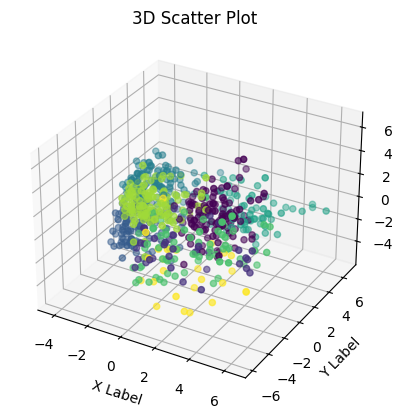

In [41]:
pca3 = PCA(n_components=3)
reduce_df3 = pca3.fit(standardized_df)
reduce_df3 = pca3.transform(standardized_df)
reduce_df3 = pd.DataFrame(data = reduce_df3, columns=["PC1", "PC2", "PC3"])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = reduce_df3["PC1"]
y = reduce_df3["PC2"]
z = reduce_df3["PC3"]

ax.scatter(x, y, z,c = preds)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')

plt.show()